# Determining the age of alcohol buyers

## Exploratory data analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [5]:
labels.shape

(7591, 2)

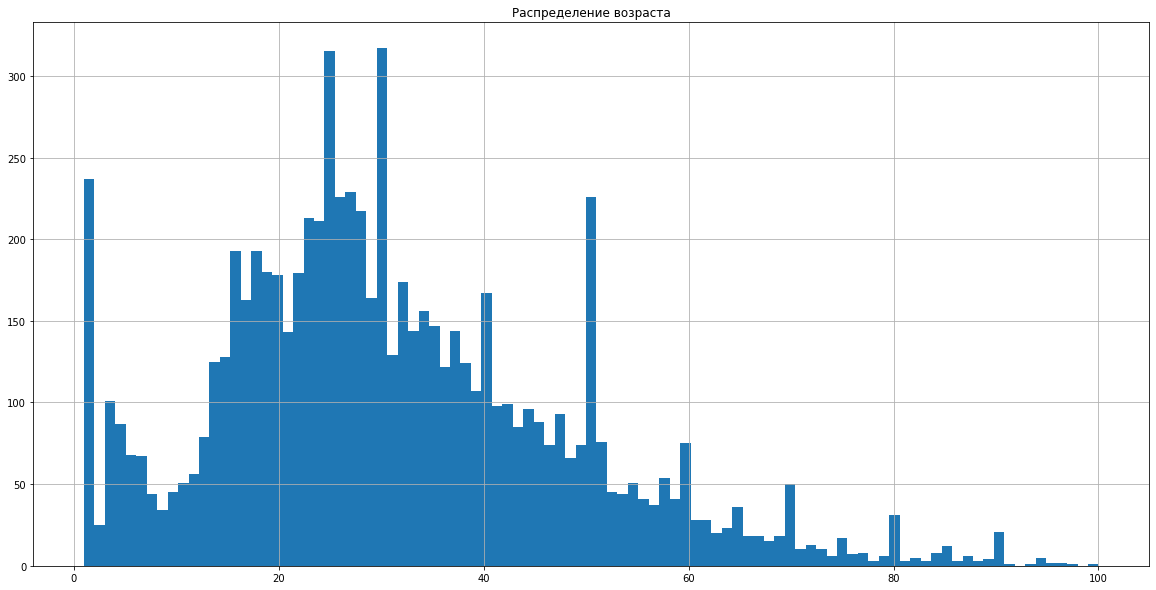

In [4]:
labels['real_age'].hist(bins = len(labels['real_age'].unique()),
                     figsize = (20,10))
plt.title('Распределение возраста')
plt.show()

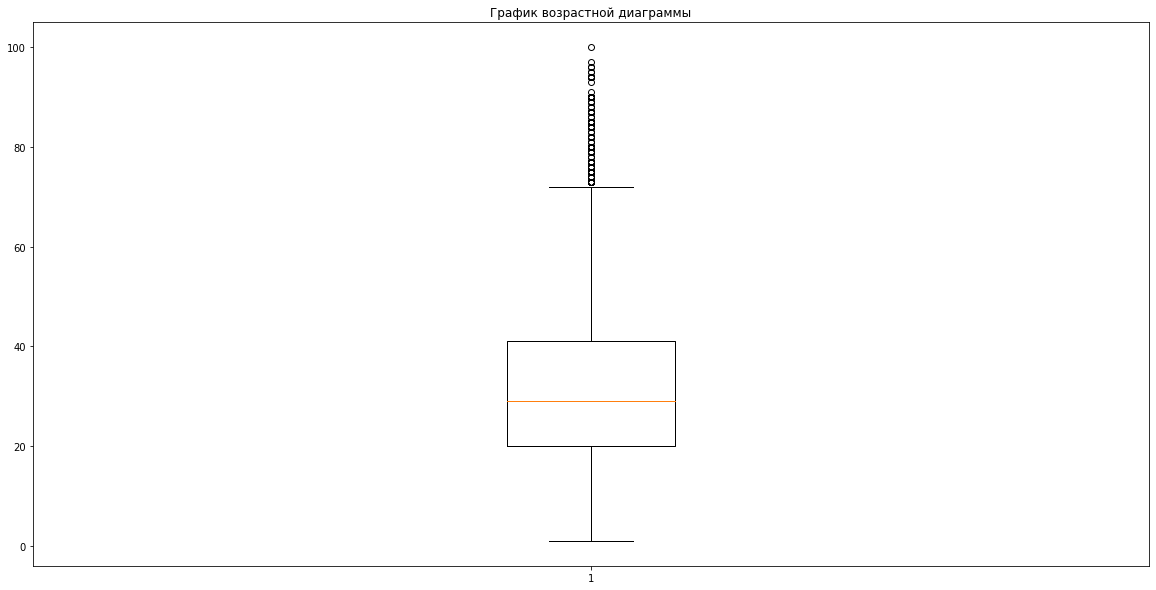

In [5]:
plt.figure(figsize=(20, 10))
plt.boxplot(labels['real_age'])
plt.title('График возрастной диаграммы')
plt.show()

In [8]:
max(labels['real_age'])


100

In [9]:
min(labels['real_age'])

1

We are looking at the first images of the training dataset.

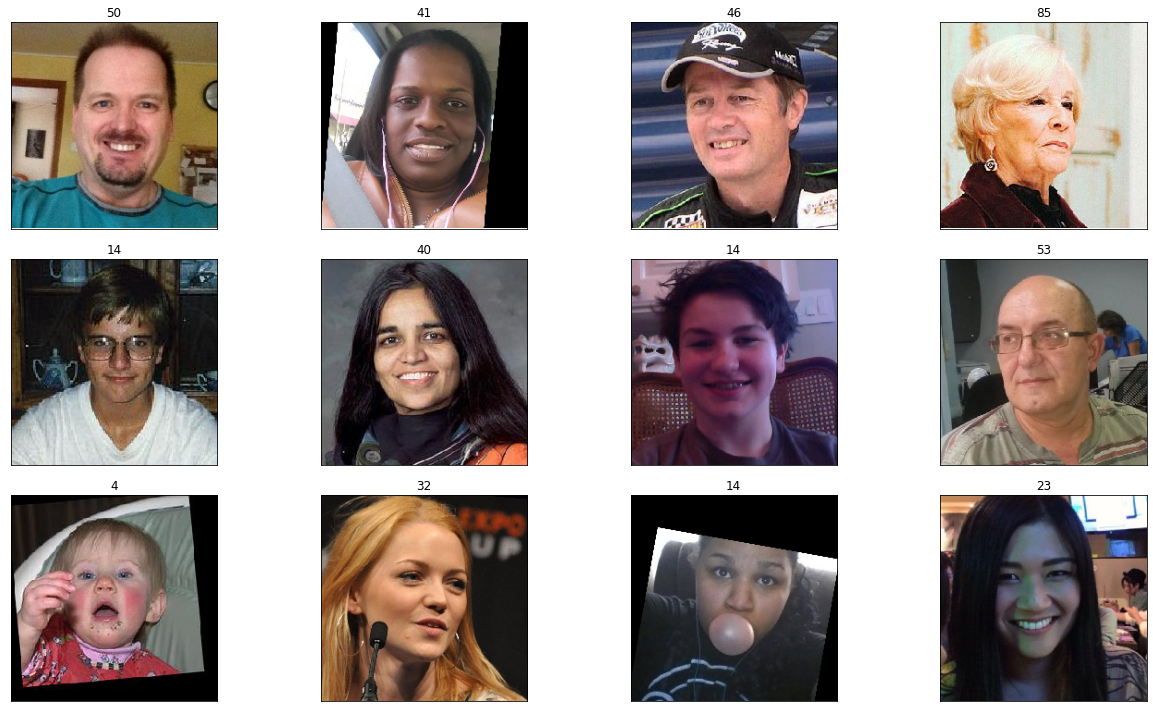

In [11]:
x, y = next(train_gen_flow)
fig = plt.figure(figsize = (20,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusions:

We have 7591 photos in the dataset, which allows us to train our model without fear of overtraining, we don't even need to use backbone.trainable=False. We can also use augmentation and thereby improve the results.

As for the ages in the data set, a normal distribution is shown, with the majority of ages in the range of 20-40 years. This means that we expect that at this age the model will give us fewer errors.

The age that divides the dataset into two halves is about 25 years old, the first quartile is something around 19 years old, which means that 25 percent of the dataset is younger than this age, and 75 percent is older than this age, finally, the third quartile shows us that 75 percent of the set the data are under the age of 40, and 25 percent are older than that age. The maximum age is 100 years, the minimum is 1 year.

There are several aspects that should be taken into account when working with images and that will affect our model. The photos are horizontal, you also see shades of gray and red, there are photos with brightness, but others do not have as much brightness, also we see some very clear images, but others are not as bright. We will take all these considerations into account when building the model so that the quality of the result does not deteriorate in any case.

## Model Training

Loading a training sample with a function.

In [10]:
path = '/datasets/faces/'

In [11]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

In [12]:
load_train(path)

Found 5694 validated image filenames.


То же самое мы делаем с данными тестирования.

In [13]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

In [14]:
load_test(path)

Found 1897 validated image filenames.


Мы создаем модель.

In [15]:
input_shape = (224, 224, 3)

In [16]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [17]:
create_model(input_shape)

2023-04-30 11:01:14.108350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We're starting training.

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [ ]:
train_model(create_model(input_shape), load_train(path), load_test(path), batch_size=10, epochs=10,
                steps_per_epoch=2, validation_steps=None)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/10


## Analysis of the trained model

The resnet50 model, running on a GPU, allowed the model to be trained in just 5 minutes, which is a record time, considering how resource- and time-consuming training of a neural model is.
The Standard error metric used shows us that with an indicator of 6.5, the model is able to determine the age of a person who is going to buy alcohol.